In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# data_dir = '/content/drive/MyDrive/csv_output_with_phases'b

In [2]:
data_dir = '../csv_output_with_phases'  # Replace with your directory

In [3]:
import sklearn
import xgboost

# To use gridsearch from sklearn for XGBoost, Scikit-learn versino should be lower than 1.6.0
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"XGBoost version: {xgboost.__version__}")

type(sklearn.__version__)
try:
  if sklearn.__version__ >= "1.6.0":
    raise Exception("sklearn version should be lower than 1.6.0")
except Exception as e:
  print(e)

Scikit-learn version: 1.5.2
XGBoost version: 2.1.3


In [4]:
# data head 보여주기
# data column 설명 추가

import os
import pandas as pd
import numpy as np

def load_data_from_files(data_dir):
    all_data = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            # Extract metadata from filename
            collection_id, step_info, _ = filename.split('_', 2)
            step_number = ''.join(filter(str.isdigit, step_info))
            foot = 'R' if 'R' in step_info else 'L'
            filepath = os.path.join(data_dir, filename)

            df = pd.read_csv(filepath)

            df['collection_id'] = collection_id + '_' + str(step_number) + '_' + foot
            df['filename'] = filename  # Keep track of the file
            df['time'] = pd.to_datetime(df['time'])  # Ensure 'time' column is in datetime format
            df['elapsed_time'] = (df['time'] - df['time'].min()).dt.total_seconds()
            df['gyroscope_magnitude'] = np.sqrt(df['gyroscope_x']**2 + df['gyroscope_y']**2 + df['gyroscope_z']**2)
            df['accelerometer_magnitude'] = np.sqrt(df['accelerometer_x']**2 + df['accelerometer_y']**2 + df['accelerometer_z']**2)
            cols = ['collection_id', 'elapsed_time', 'gyroscope_x', 'gyroscope_y',
                    'gyroscope_z', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'phase', 'gyroscope_magnitude', 'accelerometer_magnitude'] # , 'foot', 'filename']
            df = df[cols]
            # df = df[df['phase'] != 0]
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

data = load_data_from_files(data_dir)

In [5]:
data.head()

,collection_id,elapsed_time,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,phase,gyroscope_magnitude,accelerometer_magnitude
0,vh92aaJeQLxDazem2hN5_6_L,0.000,168.63,-158.62,-113.82,-1.026752,2.276032,-8.625400,1,257.975529,8.979536
1,vh92aaJeQLxDazem2hN5_6_L,0.005,-71.89,-272.58,-129.92,-2.516616,-1.586000,-2.127680,1,310.398510,3.657291
2,vh92aaJeQLxDazem2hN5_6_L,0.010,-129.85,-334.53,-114.10,-0.890112,-0.234240,0.258640,1,376.550333,0.956066
3,vh92aaJeQLxDazem2hN5_6_L,0.015,-206.85,-334.60,-111.30,-0.842288,0.425048,-1.624064,1,408.817530,1.878217
4,vh92aaJeQLxDazem2hN5_6_L,0.020,-223.65,-354.62,-105.70,0.108824,0.293288,-1.969568,1,432.373862,1.994256


In [6]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def preprocess_data(data):
    # Define features and target
    features = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_magnitude', 'accelerometer_magnitude']
    target = 'phase'

    # Drop rows with missing values
    data = data.dropna(subset=features + [target])

    # Drop rows with no event
    data = data[data[target] != 0]

    # Subtract the phase by 1 : XGboost takes a value from 0 ~ (num_class-1)
    data[target] = data[target] - 1

    # Normalize features
    scaler = MinMaxScaler()
    data.loc[:, features] = scaler.fit_transform(data[features])

    # Encode target labels
    label_encoder = LabelEncoder()
    data.loc[:, target] = label_encoder.fit_transform(data[target])

    return data, label_encoder

scaled_data, label_encoder = preprocess_data(data)

In [7]:
scaled_data.head()

,collection_id,elapsed_time,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,phase,gyroscope_magnitude,accelerometer_magnitude
0,vh92aaJeQLxDazem2hN5_6_L,0.000,0.691635,0.489820,0.233674,0.414113,0.588787,0.219917,0,0.242176,0.560265
1,vh92aaJeQLxDazem2hN5_6_L,0.005,0.498991,0.405266,0.212696,0.335429,0.371178,0.471328,0,0.291461,0.220911
2,vh92aaJeQLxDazem2hN5_6_L,0.010,0.452568,0.359302,0.233309,0.421329,0.447344,0.563660,0,0.353653,0.048677
3,vh92aaJeQLxDazem2hN5_6_L,0.015,0.390895,0.359250,0.236957,0.423855,0.484492,0.490814,0,0.383989,0.107475
4,vh92aaJeQLxDazem2hN5_6_L,0.020,0.377439,0.344396,0.244254,0.474086,0.477068,0.477446,0,0.406135,0.114874


### Getting the lag size (ACF)

In [8]:
from statsmodels.tsa.stattools import acf
from joblib import Parallel, delayed
import numpy as np

def compute_cutoff_lag(target, nlags=50):
    """Compute cutoff lag for a single time series."""
    acf_values, confint = acf(target, alpha=0.05, nlags=nlags)
    # confidential interval
    lower_bound = confint[1:, 0] - acf_values[1:]
    upper_bound = confint[1:, 1] - acf_values[1:]
    cutoff_lag = np.where((acf_values[1:] < lower_bound) | (acf_values[1:] > upper_bound))[0]
    if len(cutoff_lag) > 0:
        return cutoff_lag[-1] + 1  # Adjust index to match lag
    return 0

def get_lag_size(data, nlags=50):
    """Compute average cutoff lag across all collection IDs."""
    collection_ids = data['collection_id'].unique()

    # Use parallel processing for speed
    cutoff_lags = Parallel(n_jobs=-1)(delayed(compute_cutoff_lag)(
        data[data['collection_id'] == collection_id]['phase'], nlags
    ) for collection_id in collection_ids)

    lag_size = round(np.mean(cutoff_lags))
    print(f'average lag_size: {lag_size}')
    return lag_size

lag_size = get_lag_size(scaled_data)

<Figure size 1000x600 with 0 Axes>

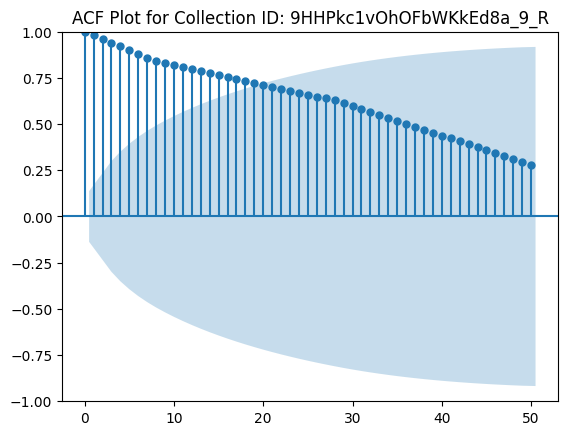

In [15]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# ACF example plot 
def plot_acf_example(data):
    random_collection_id = np.random.choice(data['collection_id'].unique(), 1, replace=False)
    phase = data[data['collection_id'] == random_collection_id[0]]['phase']
    
    plt.figure(figsize=(10, 6))
    plot_acf(phase, lags=50)
    plt.title(f'ACF Plot for Collection ID: {random_collection_id[0]}')
    plt.show()

plot_acf_example(scaled_data)

# Lagged Data Set

In [16]:
class Lagged_DataSet():
    def __init__(self, data, features, target, lag_size=30):
        self.data = data
        self.features = features
        self.len_features = len(self.features)
        self.target = target
        self.lag_size = lag_size

        self.collection_id = 0

        self.X = pd.DataFrame()
        self.y = pd.DataFrame()
        self.collection_ids = pd.DataFrame()

        for collection_id in self.data['collection_id'].unique()[:50]:
            collection_data = self.data[self.data['collection_id'] == collection_id].sort_values(by='elapsed_time')
            collection_data = collection_data[self.features + ['phase'] + ['collection_id']]
            # collection_data = collection_data[self.features + ['phase']]
            collection_length = len(collection_data)
            if collection_length > self.lag_size:
                lagged_features = {}
                for j in range(self.len_features):
                    for i in range(1, self.lag_size):
                        lagged_features[f'{self.features[j]}_lag{i}'] = collection_data[self.features[j]].shift(i)
                lagged_df = pd.DataFrame(lagged_features)
                collection_data = pd.concat([collection_data, lagged_df], axis=1)

            collection_data.dropna(inplace=True)
            collection_data['collection_id'] = self.collection_id

            collection_data = collection_data.drop(columns=self.features)
            collection_data = collection_data.dropna(axis=1, how='any')

            # self.X = pd.concat([self.X, collection_data.drop(columns=[self.target])], ignore_index=True)
            self.X = pd.concat([self.X, collection_data.drop(columns=['phase', 'collection_id'])], ignore_index=True)
            self.y = pd.concat([self.y, collection_data[[self.target]]], ignore_index=True)
            self.collection_ids = pd.concat([self.collection_ids, collection_data[['collection_id']]], ignore_index=True)

            self.collection_id += 1

        self.X_df = self.X.copy()
        self.y_df = self.y.copy()
        self.collection_ids_df = self.collection_ids.copy()

        self.X = self.X_df.values
        self.y = self.y_df.values
        self.collection_ids = self.collection_ids_df.values 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

features = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
            'accelerometer_x', 'accelerometer_y', 'accelerometer_z']
target = 'phase'
dataset = Lagged_DataSet(scaled_data, features, target, lag_size)

In [17]:
dataset.X_df.head()

,gyroscope_x_lag1,gyroscope_x_lag2,gyroscope_x_lag3,gyroscope_x_lag4,gyroscope_x_lag5,gyroscope_x_lag6,gyroscope_x_lag7,gyroscope_x_lag8,gyroscope_x_lag9,gyroscope_x_lag10,...,accelerometer_z_lag9,accelerometer_z_lag10,accelerometer_z_lag11,accelerometer_z_lag12,accelerometer_z_lag13,accelerometer_z_lag14,accelerometer_z_lag15,accelerometer_z_lag16,accelerometer_z_lag17,accelerometer_z_lag18
0,0.574568,0.573335,0.569859,0.565710,0.564196,0.560832,0.560327,0.565317,0.559094,0.540087,...,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814,0.563660,0.471328,0.219917
1,0.573279,0.574568,0.573335,0.569859,0.565710,0.564196,0.560832,0.560327,0.565317,0.559094,...,0.467684,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814,0.563660,0.471328
2,0.568569,0.573279,0.574568,0.573335,0.569859,0.565710,0.564196,0.560832,0.560327,0.565317,...,0.467835,0.467684,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814,0.563660
3,0.565710,0.568569,0.573279,0.574568,0.573335,0.569859,0.565710,0.564196,0.560832,0.560327,...,0.475916,0.467835,0.467684,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814
4,0.565429,0.565710,0.568569,0.573279,0.574568,0.573335,0.569859,0.565710,0.564196,0.560832,...,0.480618,0.475916,0.467835,0.467684,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446


In [19]:
np.unique(dataset.y)

array([0, 1, 2, 3])

cupy 관련 지워둠 

In [12]:
##### model without hyperparameter tuning

# Test run 용.
# XGboost 설명
# XGBoost 파라미터 설명
# sample_weights 파라미터 설명 ( final report에서는 빼기 )
# groupKFold 설명
# GroupShuffleSplit 설명

from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, GridSearchCV, train_test_split, GroupShuffleSplit
import numpy as np
# import cupy as cp
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, classification_report
from sklearn.utils import class_weight
import matplotlib.pyplot as plt


def get_train_test_idx(dataset):
    groups = dataset.collection_ids_df['collection_id']
    gs = GroupShuffleSplit(n_splits=2, test_size=.2, random_state=0)
    train_idx, test_idx = next(gs.split(dataset.X, dataset.y, groups=groups))
    return train_idx, test_idx

def train_XGBoost(dataset, xgb_params, n_splits = 5):
    groups = dataset.collection_ids_df['collection_id']
    gkf = GroupKFold(n_splits=n_splits)
    xgb_clf = XGBClassifier(**xgb_params)

    train_idx, _ = get_train_test_idx(dataset)
    X_train, y_train, train_groups = dataset.X[train_idx], dataset.y[train_idx], groups[train_idx]

    # if cp.cuda.runtime.getDeviceCount() > 0: # if gpu available, convert numpy array to cupy array
    #     X_train = cp.asarray(X_train)

    train_accuracy_score_list =[]
    eval_accuracy_score_list = []
    train_loss_score_list = []
    eval_loss_score_list = []

    fold_train_loss_value_list = []
    fold_eval_loss_value_list = []

    for i, (train_index, val_index) in enumerate(gkf.split(X_train, y_train, train_groups)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        eval_set =[(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)]

        train_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_fold), y=y_train_fold.ravel())
        train_sample_weights = np.array([train_class_weights[int(phase)] for phase in y_train_fold.ravel()])

        xgb_clf.fit(X_train_fold, 
                    y_train_fold,
                    eval_set=eval_set,
                    sample_weight=train_sample_weights,
                    verbose=False,
                    )
        fold_result = xgb_clf.evals_result()

        train_accuracy = accuracy_score(y_train_fold, xgb_clf.predict(X_train_fold))
        val_accuracy = accuracy_score(y_val_fold, xgb_clf.predict(X_val_fold))
        train_log_loss = log_loss(y_train_fold, xgb_clf.predict_proba(X_train_fold))
        val_log_loss = log_loss(y_val_fold, xgb_clf.predict_proba(X_val_fold))

        print(f'fold_{i+1} | train_accuracy: {train_accuracy:.2f}, val_accuracy: {val_accuracy:.2f}, train_log_loss: {train_log_loss:.2f}, val_log_loss: {val_log_loss:.2f}')

        train_accuracy_score_list.append(train_accuracy)
        eval_accuracy_score_list.append(val_accuracy)
        train_loss_score_list.append(train_log_loss)
        eval_loss_score_list.append(val_log_loss)

        # Store loss values for curves per fold
        fold_train_loss_value_list.append(fold_result['validation_0']['mlogloss'])
        fold_eval_loss_value_list.append(fold_result['validation_1']['mlogloss'])


    print(f'mean_train_accuracy: {np.mean(train_accuracy_score_list):.2f}, mean_train_loss: {np.mean(train_loss_score_list):.2f}')
    print(f'mean_val_accuracy: {np.mean(eval_accuracy_score_list):.2f}, mean_val_loss: {np.mean(eval_loss_score_list):.2f}')

    # plot loss curve 
    plt.figure(figsize=(n_splits * 5, 5))
    for i in range(n_splits):
      plt.subplot(1, n_splits, i+1)
      epochs = range(len(fold_train_loss_value_list[i]))
      plt.plot(epochs, fold_train_loss_value_list[i], label='train_loss')
      plt.plot(epochs, fold_eval_loss_value_list[i], label='eval_loss')
      plt.title(f'epochs {i+1} Loss Curve')
      plt.xlabel('epochs')
      plt.ylabel('Log Loss')
      plt.legend()
      plt.grid(True)
    plt.show()


    return xgb_clf

xgb_params={
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': len(np.unique(dataset.y)),
    'seed': 42,
    'early_stopping_rounds': 10  # Check loss curve to decide early stopping rounds
}

if cp.cuda.runtime.getDeviceCount() > 0:
  xgb_params['tree_method'] = 'hist'
  xgb_params['device']= 'cuda'


naive_model = train_XGBoost(dataset, xgb_params)


fold_1 | train_accuracy: 1.00, val_accuracy: 0.90, train_log_loss: 0.05, val_log_loss: 0.30
fold_2 | train_accuracy: 0.99, val_accuracy: 0.92, train_log_loss: 0.05, val_log_loss: 0.23
fold_3 | train_accuracy: 1.00, val_accuracy: 0.91, train_log_loss: 0.06, val_log_loss: 0.28
fold_4 | train_accuracy: 1.00, val_accuracy: 0.92, train_log_loss: 0.03, val_log_loss: 0.23
fold_5 | train_accuracy: 0.99, val_accuracy: 0.90, train_log_loss: 0.07, val_log_loss: 0.29
mean_train_accuracy: 1.00, mean_train_loss: 0.05
mean_val_accuracy: 0.91, mean_val_loss: 0.27


In [13]:
def testXGBoost(dataset, model):
    _, test_idx = get_train_test_idx(dataset)
    X_test, y_test = dataset.X[test_idx], dataset.y[test_idx]

    y_pred = model.predict(X_test)

    labels = range(len(np.unique(y_test)))
    class_names = ['heel strike', 'foot flat', 'heel off', 'toe off']
    print(classification_report(y_test, y_pred, labels=labels, target_names=class_names))

testXGBoost(dataset, model)

              precision    recall  f1-score   support

 heel strike       0.86      0.88      0.87        58
   foot flat       0.94      0.98      0.96       619
    heel off       0.97      0.91      0.94       421
     toe off       1.00      0.99      0.99       776

    accuracy                           0.97      1874
   macro avg       0.94      0.94      0.94      1874
weighted avg       0.97      0.97      0.97      1874



In [14]:
# Final report 추가 
# XGboost 설명   
# XGBoost 파라미터 설명
# sample_weights 파라미터 설명 ( final report에서는 빼기 )
# groupKFold 설명 
# GroupShuffleSplit 설명

from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, GridSearchCV, train_test_split, GroupShuffleSplit
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, classification_report
import matplotlib.pyplot as plt
# import cupy as cp

def get_train_test_idx(dataset):
    groups = dataset.collection_ids_df['collection_id']
    gs = GroupShuffleSplit(n_splits=2, test_size=.2, random_state=0)
    train_idx, test_idx = next(gs.split(dataset.X, dataset.y, groups=groups))

    return train_idx, test_idx

def train_XGBoost_grid_search(dataset, xgb_param_grid):
    groups = dataset.collection_ids_df['collection_id']
    gkf = GroupKFold(n_splits=5)
    xgb_clf = XGBClassifier(objective='multi:softmax', 
                            eval_metric='mlogloss', 
                            device='cuda', 
                            num_class=4, 
                            seed=42)

    train_idx, _ = get_train_test_idx(dataset)
    X_train, y_train, train_groups = dataset.X[train_idx], dataset.y[train_idx], groups[train_idx]
    
    # if cupy.cuda.runtime.getDeviceCount() > 0: # if gpu available, convert numpy array to cupy array 
    #   X_train = cp.asarray(X_train)

    xgb_grid = GridSearchCV(
        xgb_clf,
        param_grid=xgb_param_grid,
        cv=gkf,
        scoring='accuracy',
        n_jobs=1,
        verbose=3
    )

    grid_result = xgb_grid.fit(
        X_train,
        y_train,
        groups=train_groups,
        verbose=0
    )

    print(f'best score:{grid_result.best_score_}')
    print(f'best param:{grid_result.best_params_}')

    model = grid_result.best_estimator_ 
    return model

xgb_param_grid = {
  'n_estimators': [100], # 300, 500, 700, 900], # dafault : 100
  'learning_rate': [0.1], # 0.1, 0.5],  # default : 0.1
  'max_depth': [6], # 7, 9], # default : 6
  'reg_alpha': [0], # 0.1, 0.5], # default : 0
  'reg_lambda': [1], # 0.5, 1.0], # default : 1
  'objective': ['multi:softmax'], 
  'eval_metric': ['mlogloss'],
  'seed': [42],
  'num_class': [len(np.unique(dataset.y))]
}

if cp.cuda.runtime.getDeviceCount() > 0:
  xgb_param_grid['tree_method'] = ['hist']
  xgb_params['device']= ['cuda']

model = train_XGBoost_grid_search(dataset, xgb_param_grid)

ModuleNotFoundError: No module named 'cupy'

In [ ]:
for id in dataset.collection_ids_df['collection_id'].unique():
    mask = dataset.collection_ids_df['collection_id'].isin([id])
    zero_mask = dataset[mask].y[dataset.y_df['target'] == 0]
    # print(np.unique(dataset.y[mask]), np.unique(dataset.collection_ids_df[mask]))

In [15]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 


def test_XGBoost_grid_result(dataset, model):
    _, test_idx = get_train_test_idx(dataset)
    X_test, y_test = dataset.X[test_idx], dataset.y[test_idx]

    y_pred = model.predict(X_test)
    # print(f'test accuracy: {accuracy_score(y_test, model.predict(X_test)):.2f}')  

    labels = range(len(np.unique(y_test)))
    class_names = ['heel strike', 'foot flat', 'heel off', 'toe off']
    print(classification_report(y_test, y_pred, labels=labels, target_names=class_names))

test_XGBoost_grid_result(dataset, model)

              precision    recall  f1-score   support

 heel strike       0.86      0.88      0.87        58
   foot flat       0.94      0.98      0.96       619
    heel off       0.97      0.91      0.94       421
     toe off       1.00      0.99      0.99       776

    accuracy                           0.97      1874
   macro avg       0.94      0.94      0.94      1874
weighted avg       0.97      0.97      0.97      1874



In [ ]:
#### Grid Search with Early Stopping 
# # Final report 추가
# # XGboost 설명
# # XGBoost 파라미터 설명
# # sample_weights 파라미터 설명 ( final report에서는 빼기 )
# # groupKFold 설명 -> 하나의 그룹은 테스트 인덱스, 나머지 그룹은 
# # GroupShuffleSplit 설명 -> 

# Manual로 실행한 이유 -> early stopping / sample weight을 사이킷런 grid search 모듈을 사용할 경우 설정이 어려움 
'''
  [TODO] Implementing Grid Search Manually

  https://xgboosting.com/xgboost-early-stopping-with-grid-search/
  https://gist.github.com/sandys/d0acf13976bae81df253d0a09436cb2b
'''
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, GridSearchCV, train_test_split, GroupShuffleSplit
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, classification_report
import matplotlib.pyplot as plt
import numpy as np
# import cupy as cp
import itertools
import time 

def get_train_test_idx(dataset):
    groups = dataset.collection_ids_df['collection_id']
    gs = GroupShuffleSplit(n_splits=2, test_size=.2, random_state=42) # 동일한 그룹에 속한 데이터는 훈련 세트와 테스트 세트에 중복되지 않도록 보장
    train_idx, test_idx = next(gs.split(dataset.X, dataset.y, groups=groups))

    return train_idx, test_idx

def train_XGBoost_manual_grid_search(dataset, xgb_param_grid):
    # n_collection_dis = len(np.unique(dataset.collection_ids))

    # early stopping
    early_stopping_rounds = 15

    # train dataset
    train_idx, _ = get_train_test_idx(dataset)
    groups = dataset.collection_ids_df['collection_id']
    X_train, y_train, train_groups = dataset.X[train_idx], dataset.y[train_idx], groups[train_idx]

    # if cp.cuda.runtime.getDeviceCount() > 0: # if gpu available, convert numpy array to cupy array
    #     X_train = cp.asarray(X_train) 

    n_splits = 10 # if the split too bit, for example 1800, toe off might not be included in the test set 
    gkf = GroupKFold(n_splits=n_splits)
    xgb_clf = XGBClassifier()

    # calculate the total rounds
    param_values = list(xgb_param_grid.values())
    all_combinations = list(itertools.product(*param_values))
    total_combinations = len(all_combinations)
    total_round = total_combinations * n_splits
    current_round = 1
    print(f'total round: {total_round}')

    # best score 
    best_score = 0


    for n_estimators in xgb_param_grid['n_estimators']:
        for learning_rate in xgb_param_grid['learning_rate']:
            for max_depth in xgb_param_grid['max_depth']:
                for reg_alpha in xgb_param_grid['reg_alpha']:
                    for reg_lambda in xgb_param_grid['reg_lambda']:
                        print(f'current params: n_estimators:{n_estimators:}, learning_rate:{learning_rate}, max_depth:{max_depth}, reg_alpha:{reg_alpha}, reg_lambda:{reg_lambda}, early_stopping_rounds:{early_stopping_rounds}')
                        
                        start_time = time.process_time()

                        train_accuracy_list = []
                        train_log_loss_list = []
                        val_accuracy_list = []
                        val_log_loss_list = []

                        for i, (train_index, val_index) in enumerate(gkf.split(X_train, y_train, train_groups)):
                            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
                            eval_set = [(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)]

                            # give more weight to the minor class 
                            # train_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_fold), y=y_train_fold.ravel())
                            # train_sample_weights = np.array([train_class_weights[int(phase)] for phase in y_train_fold.ravel()])

                            xgb_clf.set_params(
                                n_estimators=n_estimators,
                                learning_rate=learning_rate,
                                max_depth=max_depth,
                                reg_alpha=reg_alpha,
                                reg_lambda=reg_lambda,
                                early_stopping_rounds = early_stopping_rounds,
                                objective=xgb_param_grid['objective'][0],
                                eval_metric=xgb_param_grid['eval_metric'][0],
                                seed=xgb_param_grid['seed'][0],
                                num_class=xgb_param_grid['num_class'][0],
                            )

                            xgb_clf.fit(
                                X_train_fold,
                                y_train_fold,
                                eval_set=eval_set,
                                # sample_weight=train_sample_weights,
                                verbose=False
                            )

                            train_accuracy = accuracy_score(y_train_fold, xgb_clf.predict(X_train_fold))
                            val_accuracy = accuracy_score(y_val_fold, xgb_clf.predict(X_val_fold))
                            train_log_loss = log_loss(y_train_fold, xgb_clf.predict_proba(X_train_fold))
                            val_log_loss = log_loss(y_val_fold, xgb_clf.predict_proba(X_val_fold))

                            train_accuracy_list.append(train_accuracy)
                            val_accuracy_list.append(val_accuracy)
                            train_log_loss_list.append(train_log_loss)
                            val_log_loss_list.append(val_log_loss)

                            end_time = time.process_time() 

                            print(f'{current_round}/{total_round} | Fold:{i+1}/{n_splits} | val_accuracy: {val_accuracy:.6f} | train_accuracy: {train_accuracy:.6f}, train_log_loss: {train_log_loss:.6f}, val_log_loss: {val_log_loss:.6f}, time: {(end_time - start_time):.4f}')
                            current_round += 1

                        # Compute average score across all folds
                        average_val_accuracy = np.mean(val_accuracy_list)
                        print(f'avg_val_accuracy: {average_val_accuracy:.6f} | avg train_accracy: {np.mean(train_accuracy):.6f}, avg_train_loss: {np.mean(train_log_loss_list):.6f}, avg_val_loss: {np.mean(val_log_loss_list):.6f}')
                        if average_val_accuracy > best_score:
                            best_score = average_val_accuracy
                            best_params = {
                                'n_estimators': n_estimators,
                                'learning_rate': learning_rate,
                                'max_depth': max_depth,
                                'reg_alpha': reg_alpha,
                                'reg_lambda': reg_lambda,
                                'objective': xgb_param_grid['objective'],
                                'eval_metric': xgb_param_grid['eval_metric'],
                                'seed': xgb_param_grid['seed'],
                                'num_class': xgb_param_grid['num_class'],
                                'early_stopping_rounds': early_stopping_rounds
                            }
                            # best_result = xgb_clf.evals_result() # keep the values 
                            best_model = xgb_clf

    print(f'Best Accuracy:{best_score:.6f}')
    print(f'Best Params:\n {best_params}')
    return best_model

xgb_param_manual_grid = {
    'n_estimators': [100], #[100, 300, 500, 700], # dafault : 100
    'learning_rate': [0.05], #[0.05 , 0.1, 0.5],  # default : 0.1
    'max_depth': [10], #[4, 6, 8, 10], # default : 6
    'reg_alpha': [0], #[0, 0.1, 0.5], # default : 0
    'reg_lambda': [0.1], # [0.1, 0.5, 1.0], # default : 1
    'objective': ['multi:softmax'],
    'eval_metric': ['mlogloss'],
    'seed': [42],
    'num_class': [len(np.unique(dataset.y))],
}

# if cp.cuda.runtime.getDeviceCount() > 0:
#     xgb_param_manual_grid['tree_method'] = ['hist']
#     xgb_param_manual_grid['device'] = ['cuda']
#     print('training running on cuda')

manual_grid_model = train_XGBoost_manual_grid_search(dataset, xgb_param_manual_grid)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def test_XGBoost_grid_result(dataset, model):
    _, test_idx = get_train_test_idx(dataset)
    X_test, y_test, test_groups = dataset.X[test_idx], dataset.y[test_idx], dataset.collection_ids[test_idx]
    print(f'test on {len(np.unique(test_groups))} collection ids:{np.unique(test_groups)}')

    y_pred = model.predict(X_test)
    print(f'test accuracy: {accuracy_score(y_test, model.predict(X_test)):.2f}')

    labels = range(len(np.unique(y_test)))
    class_names = ['heel strike', 'foot flat', 'heel off', 'toe off']
    print(classification_report(y_test, y_pred, labels=labels, target_names=class_names))

test_XGBoost_grid_result(dataset, manual_grid_model)